In [40]:
! pip install geopy

     ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
     -------------------------------------- 40.3/40.3 kB 970.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   ---------------------- ----------------- 71.7/125.4 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 125.4/125.4 kB 1.8 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Importing Libraries

In [3]:
import pandas as pd
import os
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import json
import requests
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import folium
import warnings
warnings.filterwarnings('ignore')

Importing and Loading Datasets

In [19]:
combined_df = pd.DataFrame()

In [20]:
dataset_path = r"datasets/"
for file in os.listdir(dataset_path):
    if file.endswith(".csv"):
        file_path = os.path.join(dataset_path, file)
        df = pd.read_csv(file_path)
        combined_df = pd.concat([combined_df, df], ignore_index=True)

combined_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN


In [22]:
len(combined_df['street_name'].unique())

584

In [21]:
combined_df['street_name'].unique()

array(['ANG MO KIO AVE 1', 'ANG MO KIO AVE 3', 'ANG MO KIO AVE 4',
       'ANG MO KIO AVE 10', 'ANG MO KIO AVE 5', 'ANG MO KIO AVE 8',
       'ANG MO KIO AVE 6', 'ANG MO KIO AVE 9', 'ANG MO KIO AVE 2',
       'BEDOK RESERVOIR RD', 'BEDOK NTH ST 3', 'BEDOK STH RD',
       'NEW UPP CHANGI RD', 'BEDOK NTH RD', 'BEDOK STH AVE 1',
       'CHAI CHEE RD', 'CHAI CHEE DR', 'BEDOK NTH AVE 4',
       'BEDOK STH AVE 3', 'BEDOK STH AVE 2', 'BEDOK NTH ST 2',
       'BEDOK NTH ST 4', 'BEDOK NTH AVE 2', 'BEDOK NTH AVE 3',
       'BEDOK NTH AVE 1', 'BEDOK NTH ST 1', 'CHAI CHEE ST', 'SIN MING RD',
       'SHUNFU RD', 'BT BATOK ST 11', 'BT BATOK WEST AVE 8',
       'BT BATOK WEST AVE 6', 'BT BATOK ST 21', 'BT BATOK EAST AVE 5',
       'BT BATOK EAST AVE 4', 'HILLVIEW AVE', 'BT BATOK CTRL',
       'BT BATOK ST 31', 'BT BATOK EAST AVE 3', 'TAMAN HO SWEE',
       'TELOK BLANGAH CRES', 'BEO CRES', 'TELOK BLANGAH DR', 'DEPOT RD',
       'TELOK BLANGAH RISE', 'JLN BT MERAH', 'HENDERSON RD', 'INDUS RD',
       

In [23]:
combined_df['flat_type'].unique()

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE',
       'MULTI GENERATION', 'MULTI-GENERATION'], dtype=object)

In [25]:
combined_df['block'].value_counts()

block
2       4566
1       4015
110     3391
101     3383
4       3321
        ... 
226E       2
460A       1
226F       1
437A       1
606D       1
Name: count, Length: 2703, dtype: int64

In [32]:
d = combined_df.copy()
print(d['lease_commence_date'].min())
print(d['lease_commence_date'].max())

1966
2022


### Data Preprocessing & Feature Engineering

In [4]:
combined_df.shape

(917531, 11)

Handle null values

In [5]:
combined_df.isnull().sum()

month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
remaining_lease        709050
dtype: int64

In [6]:
combined_df.dropna(inplace=True)
combined_df.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
remaining_lease        0
dtype: int64

Get List of MRT Stations from the site "https://mrtmapsingapore.com/mrt-stations-singapore/#google_vignette"

In [35]:
mrt_list=[]
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
driver = webdriver.Chrome(options=options)
driver.maximize_window()
driver.get("https://mrtmapsingapore.com/mrt-stations-singapore/#google_vignette")
driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.PAGE_DOWN)
time.sleep(3)

table = driver.find_element(By.XPATH,"//table[@class='tablepress tablepress-id-1 tablepress-responsive dataTable no-footer']")
rows = table.find_elements(By.CSS_SELECTOR, 'tbody>tr')


for row in rows:
    mrt_list.append(row.find_elements(By.TAG_NAME, 'td')[1].text)
    
driver.close()   

In [8]:
mrt_list

['Jurong East',
 'Bukit Batok',
 'Bukit Gombak',
 'Choa Chu Kang',
 'Yew Tee',
 'Kranji',
 'Marsiling',
 'Woodlands',
 'Admiralty',
 'Sembawang',
 'Canberra',
 'Yishun',
 'Khatib',
 'Yio Chu Kang',
 'Ang Mo Kio',
 'Bishan',
 'Braddell',
 'Toa Payoh',
 'Novena',
 'Newton',
 'Orchard',
 'Somerset',
 'Dhoby Ghaut',
 'City Hall',
 'Raffles Place',
 'Marina Bay',
 'Marina South Pier',
 'Pasir Ris',
 'Tampines',
 'Simei',
 'Tanah Merah',
 'Bedok',
 'Kembangan',
 'Eunos',
 'Paya Lebar',
 'Aljunied',
 'Kallang',
 'Lavender',
 'Bugis',
 'City Hall',
 'Raffles Place',
 'Tanjong Pagar',
 'Outram Park',
 'Tiong Bahru',
 'Redhill',
 'Queenstown',
 'Commonwealth',
 'Buona Vista',
 'Dover',
 'Clementi',
 'Jurong East',
 'Chinese Garden',
 'Lakeside',
 'Boon Lay',
 'Pioneer',
 'Joo Koon',
 'Gul Circle',
 'Tuas Crescent',
 'Tuas West Road',
 'Tuas Link',
 'Expo',
 'Changi Airport',
 'HarbourFront',
 'Outram Park',
 'Chinatown',
 'Clarke Quay',
 'Dhoby Ghaut',
 'Little India',
 'Farrer Park',
 'Boon Ken

In [9]:
combined_df['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

Get Coordinates of each MRT Station

In [36]:
mrt_lat = []
mrt_long = []

for i in range(0, len(mrt_list)):
    query_address = mrt_list[i]+" MRT Station"
    query_string = 'https://www.onemap.gov.sg/api/common/elastic/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
    resp = requests.get(query_string)
    data_mrt=json.loads(resp.content)

    if data_mrt['found'] != 0:
        mrt_lat.append(data_mrt["results"][0]["LATITUDE"])
        mrt_long.append(data_mrt["results"][0]["LONGITUDE"])
    else:
        mrt_lat.append('NotFound')
        mrt_lat.append('NotFound')
        

In [37]:
mrt_loc = pd.DataFrame({
    'MRT': mrt_list,
    'latitude': mrt_lat,
    'longitude': mrt_long
})

In [38]:
mrt_loc

,MRT,latitude,longitude
0,Jurong East,1.33315281585758,103.742286332403
1,Bukit Batok,1.34903534800639,103.749526027989
2,Bukit Gombak,1.35871216207818,103.751883836125
3,Choa Chu Kang,1.38536316540225,103.744370779756
4,Yew Tee,1.39757979021386,103.747459490883
...,...,...,...
140,Upper Changi,1.34173977444995,103.961472788634
141,Expo,1.33538252614956,103.962374747451
142,Woodlands North,1.44778217342648,103.7851355073
143,Woodlands,1.43605761708128,103.787938777173


In [39]:
mrt_loc.to_csv('mrt_loc.csv', index=False)

##### Get the Coordinates,Block No,Postal Code etc. of each HDB Flats ( Housing and Development Board)

Get address using block and street

In [14]:
combined_df['address']=combined_df['block']+" "+combined_df['street_name']

In [47]:
combined_df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,address
656847,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,255000.0,70.0,174 ANG MO KIO AVE 4
656848,2015-01,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,275000.0,65.0,541 ANG MO KIO AVE 10
656849,2015-01,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,285000.0,64.0,163 ANG MO KIO AVE 4
656850,2015-01,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,290000.0,63.0,446 ANG MO KIO AVE 10
656851,2015-01,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,290000.0,64.0,557 ANG MO KIO AVE 10
...,...,...,...,...,...,...,...,...,...,...,...,...
865323,2024-01,YISHUN,EXECUTIVE,325,YISHUN CTRL,04 TO 06,146.0,Maisonette,1988,783000.0,63 years 11 months,325 YISHUN CTRL
865324,2024-01,YISHUN,EXECUTIVE,356,YISHUN RING RD,04 TO 06,146.0,Maisonette,1988,860000.0,63 years 08 months,356 YISHUN RING RD
865325,2024-01,YISHUN,EXECUTIVE,360,YISHUN RING RD,04 TO 06,146.0,Maisonette,1988,888000.0,63 years 07 months,360 YISHUN RING RD
865326,2024-01,YISHUN,EXECUTIVE,387,YISHUN RING RD,10 TO 12,146.0,Maisonette,1988,795000.0,63 years 05 months,387 YISHUN RING RD


In [15]:
address_list = combined_df['address'].unique()

In [16]:
address_list

array(['174 ANG MO KIO AVE 4', '541 ANG MO KIO AVE 10',
       '163 ANG MO KIO AVE 4', ..., '606A TAMPINES ST 61',
       '606D TAMPINES ST 61', '823 YISHUN ST 81'], dtype=object)

In [17]:
len(address_list)

9562

In [21]:
lat = []
long = []
block_no=[]
road_name=[]
postal_code=[]
address=[]
        

In [33]:
for i in range(8000, len(address_list)):
    query_address = address_list[i]
    query_string='https://www.onemap.gov.sg/api/common/elastic/search?searchVal='+str(query_address)+'&returnGeom=Y&getAddrDetails=Y'
    resp = requests.get(query_string)
    data_geo_location=json.loads(resp.content)
    try:
        if data_geo_location['found'] != 0:
                lat.append(data_geo_location['results'][0]['LATITUDE'])
                long.append(data_geo_location['results'][0]['LONGITUDE'])
                block_no.append(data_geo_location['results'][0]['BLK_NO'])
                road_name.append(data_geo_location['results'][0]['ROAD_NAME'])
                postal_code.append(data_geo_location['results'][0]['POSTAL'])
                address.append(query_address)
        else:
            print ("No Results")
    except:
         print(query_address)
    

In [36]:
df_flat_coordinates = pd.DataFrame({
    'latitude': lat,
    'longitude': long,
    'blk_no': block_no,
    'road_name': road_name,
    'postal_code': postal_code,
    'address': address
})


df_flat_coordinates.drop_duplicates(inplace=True)


In [37]:
len(df_flat_coordinates)

8578

In [38]:
df_flat_coordinates

,latitude,longitude,blk_no,road_name,postal_code,address
0,1.37509746867904,103.83761896123,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4
1,1.37392239168826,103.855621371068,541,ANG MO KIO AVENUE 10,560541,541 ANG MO KIO AVE 10
2,1.37355178595963,103.838168959329,163,ANG MO KIO AVENUE 4,560163,163 ANG MO KIO AVE 4
3,1.36776094720351,103.85535715026,446,ANG MO KIO AVENUE 10,560446,446 ANG MO KIO AVE 10
4,1.3716257020332,103.857736107527,557,ANG MO KIO AVENUE 10,560557,557 ANG MO KIO AVE 10
...,...,...,...,...,...,...
10411,1.32238824783966,103.862438814371,26A,SAINT GEORGE'S LANE,321026,26A ST. GEORGE'S LANE
10412,1.41239137117199,103.898233670211,323A,SUMANG WALK,821323,323A SUMANG WALK
10413,1.36237689129671,103.936586944758,606A,TAMPINES STREET 61,521606,606A TAMPINES ST 61
10414,1.36185122194834,103.937073184127,606D,TAMPINES STREET 61,524606,606D TAMPINES ST 61


In [39]:
flat_coordinates = []
mrt_coordinates =[]

for lat,long in zip(df_flat_coordinates['latitude'],df_flat_coordinates['longitude']):
    flat_coordinates.append((lat,long))

for lat,long in zip(mrt_loc['latitude'],mrt_loc['longitude']):
    mrt_coordinates.append((lat,long))

##### Get the Distance b/w MRT and HDB Flat , CBD and HDB Flat

In [41]:
# Distance to nearest MRT
from geopy.distance import geodesic

list_of_dist_mrt = []
min_dist_mrt = []

for origin in flat_coordinates:
    for destination in range(0, len(mrt_coordinates)):
        list_of_dist_mrt.append(geodesic(origin,mrt_coordinates[destination]).meters)
    shortest = (min(list_of_dist_mrt))
    min_dist_mrt.append(shortest)
    list_of_dist_mrt.clear()

In [42]:
# Distance from CDB
cbd_dist = []

for origin in flat_coordinates:
    cbd_dist.append(geodesic(origin,(1.2830, 103.8513)).meters) #CBD coordinates

In [43]:
# Put MRT and CBD distance together
df_flat_coordinates['cbd_dist'] = cbd_dist
df_flat_coordinates['min_dist_mrt'] = min_dist_mrt

In [44]:
df_flat_coordinates

,latitude,longitude,blk_no,road_name,postal_code,address,cbd_dist,min_dist_mrt
0,1.37509746867904,103.83761896123,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832
1,1.37392239168826,103.855621371068,541,ANG MO KIO AVENUE 10,560541,541 ANG MO KIO AVE 10,10065.227934,806.176499
2,1.37355178595963,103.838168959329,163,ANG MO KIO AVENUE 4,560163,163 ANG MO KIO AVE 4,10118.831546,1174.458648
3,1.36776094720351,103.85535715026,446,ANG MO KIO AVENUE 10,560446,446 ANG MO KIO AVE 10,9383.300476,688.601573
4,1.3716257020332,103.857736107527,557,ANG MO KIO AVENUE 10,560557,557 ANG MO KIO AVE 10,9825.917255,929.164159
...,...,...,...,...,...,...,...,...
10411,1.32238824783966,103.862438814371,26A,SAINT GEORGE'S LANE,321026,26A ST. GEORGE'S LANE,4528.332931,274.150118
10412,1.41239137117199,103.898233670211,323A,SUMANG WALK,821323,323A SUMANG WALK,15231.037948,1357.226309
10413,1.36237689129671,103.936586944758,606A,TAMPINES STREET 61,521606,606A TAMPINES ST 61,12927.779965,1836.464335
10414,1.36185122194834,103.937073184127,606D,TAMPINES STREET 61,524606,606D TAMPINES ST 61,12928.291352,1800.198404


In [45]:
df_flat_coordinates.to_csv('df_flat_coordinates.csv',index=False)

In [62]:
df_flat_coordinates = pd.read_csv('df_flat_coordinates.csv')

In [63]:
df_new = df_flat_coordinates.merge(combined_df, on='address', how='outer')
df_new

,latitude,longitude,blk_no,road_name,postal_code,address,cbd_dist,min_dist_mrt,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,255000.0,70.0
1,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2015-12,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,10 TO 12,60.0,Improved,1986,275000.0,69.0
2,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2016-05,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,69.0,Improved,1986,310000.0,68.0
3,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2016-06,ANG MO KIO,2 ROOM,174,ANG MO KIO AVE 4,07 TO 09,45.0,Improved,1986,253000.0,68.0
4,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2016-11,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,290000.0,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208772,NaN,NaN,NaN,NaN,NaN,153 BISHAN ST 13,NaN,NaN,2022-03,BISHAN,4 ROOM,153,BISHAN ST 13,07 TO 09,84.0,Simplified,1987,528000.0,64 years 07 months
208773,NaN,NaN,NaN,NaN,NaN,153 BISHAN ST 13,NaN,NaN,2022-09,BISHAN,5 ROOM,153,BISHAN ST 13,01 TO 03,121.0,Improved,1987,780000.0,64 years 02 months
208774,NaN,NaN,NaN,NaN,NaN,153 BISHAN ST 13,NaN,NaN,2022-10,BISHAN,4 ROOM,153,BISHAN ST 13,07 TO 09,84.0,Simplified,1987,605000.0,64 years
208775,NaN,NaN,NaN,NaN,NaN,153 BISHAN ST 13,NaN,NaN,2023-04,BISHAN,4 ROOM,153,BISHAN ST 13,01 TO 03,84.0,Simplified,1987,498000.0,63 years 07 months


In [64]:
df_new.dtypes

latitude               float64
longitude              float64
blk_no                  object
road_name               object
postal_code             object
address                 object
cbd_dist               float64
min_dist_mrt           float64
month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
remaining_lease         object
dtype: object

Note : This is applicable for HDB Flats for Singapore only

In Singapore, more than 75% of the land belongs to Singapore Land Authority (STA), while the remaining freehold land belongs to statutory boards like HDB, JTC, PSA and other private owners.

Before you assume that every house in Singapore is on a 99-year lease and start panicking about the impending expiry date, it’s important to be very clear on your property’s leasehold type. There are three leasehold types: 99-year lease, 999-year lease and freehold.

All HDB flats have a 99-year lease, while private properties are available in all three leasehold types. However, the government has stopped providing 999-year leases and hence the most common lease type is the 99-year lease. Since 999 years is a long time, houses with a 999-year lease or freehold lease are highly sought after.

In [65]:
df_new['lease_remaining_years'] = 99 - (2024-df_new['lease_commence_date'])

In [66]:
df_new.dropna(inplace=True)

df_new

,latitude,longitude,blk_no,road_name,postal_code,address,cbd_dist,min_dist_mrt,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,lease_remaining_years
0,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2015-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,255000.0,70.0,61
1,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2015-12,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,10 TO 12,60.0,Improved,1986,275000.0,69.0,61
2,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2016-05,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,69.0,Improved,1986,310000.0,68.0,61
3,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2016-06,ANG MO KIO,2 ROOM,174,ANG MO KIO AVE 4,07 TO 09,45.0,Improved,1986,253000.0,68.0,61
4,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2016-11,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,290000.0,68.0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189414,1.362377,103.936587,606A,TAMPINES STREET 61,521606,606A TAMPINES ST 61,12927.779965,1836.464335,2024-01,TAMPINES,3 ROOM,606A,TAMPINES ST 61,10 TO 12,68.0,Model A,2020,508000.0,95 years 02 months,95
189415,1.362377,103.936587,606A,TAMPINES STREET 61,521606,606A TAMPINES ST 61,12927.779965,1836.464335,2024-01,TAMPINES,4 ROOM,606A,TAMPINES ST 61,13 TO 15,92.0,Model A,2020,720000.0,95 years 02 months,95
189416,1.362377,103.936587,606A,TAMPINES STREET 61,521606,606A TAMPINES ST 61,12927.779965,1836.464335,2024-01,TAMPINES,4 ROOM,606A,TAMPINES ST 61,13 TO 15,92.0,Model A,2020,745000.0,95 years 01 month,95
189417,1.361851,103.937073,606D,TAMPINES STREET 61,524606,606D TAMPINES ST 61,12928.291352,1800.198404,2024-01,TAMPINES,4 ROOM,606D,TAMPINES ST 61,16 TO 18,92.0,Model A,2020,725000.0,95 years 01 month,95


In [67]:
df_new.dtypes

latitude                 float64
longitude                float64
blk_no                    object
road_name                 object
postal_code               object
address                   object
cbd_dist                 float64
min_dist_mrt             float64
month                     object
town                      object
flat_type                 object
block                     object
street_name               object
storey_range              object
floor_area_sqm           float64
flat_model                object
lease_commence_date        int64
resale_price             float64
remaining_lease           object
lease_remaining_years      int64
dtype: object

In [68]:
df_new.isnull().sum()

latitude                 0
longitude                0
blk_no                   0
road_name                0
postal_code              0
address                  0
cbd_dist                 0
min_dist_mrt             0
month                    0
town                     0
flat_type                0
block                    0
street_name              0
storey_range             0
floor_area_sqm           0
flat_model               0
lease_commence_date      0
resale_price             0
remaining_lease          0
lease_remaining_years    0
dtype: int64

##### Some More DataPreprocessing for combined_data

In [69]:
def calculateMedian(x):
    s = [float(i) for i in x.split("TO")]
    median = statistics.median(s)
    return median

In [70]:
df_new['storey_median'] = df_new['storey_range'].apply(calculateMedian)

In [71]:
df_new

,latitude,longitude,blk_no,road_name,postal_code,address,cbd_dist,min_dist_mrt,month,town,...,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,lease_remaining_years,storey_median
0,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2015-01,ANG MO KIO,...,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,255000.0,70.0,61,8.0
1,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2015-12,ANG MO KIO,...,174,ANG MO KIO AVE 4,10 TO 12,60.0,Improved,1986,275000.0,69.0,61,11.0
2,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2016-05,ANG MO KIO,...,174,ANG MO KIO AVE 4,04 TO 06,69.0,Improved,1986,310000.0,68.0,61,5.0
3,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2016-06,ANG MO KIO,...,174,ANG MO KIO AVE 4,07 TO 09,45.0,Improved,1986,253000.0,68.0,61,8.0
4,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832,2016-11,ANG MO KIO,...,174,ANG MO KIO AVE 4,04 TO 06,61.0,Improved,1986,290000.0,68.0,61,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189414,1.362377,103.936587,606A,TAMPINES STREET 61,521606,606A TAMPINES ST 61,12927.779965,1836.464335,2024-01,TAMPINES,...,606A,TAMPINES ST 61,10 TO 12,68.0,Model A,2020,508000.0,95 years 02 months,95,11.0
189415,1.362377,103.936587,606A,TAMPINES STREET 61,521606,606A TAMPINES ST 61,12927.779965,1836.464335,2024-01,TAMPINES,...,606A,TAMPINES ST 61,13 TO 15,92.0,Model A,2020,720000.0,95 years 02 months,95,14.0
189416,1.362377,103.936587,606A,TAMPINES STREET 61,521606,606A TAMPINES ST 61,12927.779965,1836.464335,2024-01,TAMPINES,...,606A,TAMPINES ST 61,13 TO 15,92.0,Model A,2020,745000.0,95 years 01 month,95,14.0
189417,1.361851,103.937073,606D,TAMPINES STREET 61,524606,606D TAMPINES ST 61,12928.291352,1800.198404,2024-01,TAMPINES,...,606D,TAMPINES ST 61,16 TO 18,92.0,Model A,2020,725000.0,95 years 01 month,95,17.0


In [168]:
df_new.to_csv('combined_df.csv',index=False)

In [9]:
df_new = pd.read_csv('combined_df.csv')

In [10]:
req_df = df_new[['town','flat_type','block','flat_model','cbd_dist','min_dist_mrt','floor_area_sqm','lease_remaining_years','storey_median','resale_price']]
req_df.drop_duplicates(inplace=True)
req_df

,town,flat_type,block,flat_model,cbd_dist,min_dist_mrt,floor_area_sqm,lease_remaining_years,storey_median,resale_price
0,ANG MO KIO,3 ROOM,174,Improved,10296.855747,1098.780832,60.0,61,8.0,255000.0
1,ANG MO KIO,3 ROOM,174,Improved,10296.855747,1098.780832,60.0,61,11.0,275000.0
2,ANG MO KIO,3 ROOM,174,Improved,10296.855747,1098.780832,69.0,61,5.0,310000.0
3,ANG MO KIO,2 ROOM,174,Improved,10296.855747,1098.780832,45.0,61,8.0,253000.0
4,ANG MO KIO,3 ROOM,174,Improved,10296.855747,1098.780832,61.0,61,5.0,290000.0
...,...,...,...,...,...,...,...,...,...,...
189402,TAMPINES,3 ROOM,606A,Model A,12927.779965,1836.464335,68.0,95,11.0,508000.0
189403,TAMPINES,4 ROOM,606A,Model A,12927.779965,1836.464335,92.0,95,14.0,720000.0
189404,TAMPINES,4 ROOM,606A,Model A,12927.779965,1836.464335,92.0,95,14.0,745000.0
189405,TAMPINES,4 ROOM,606D,Model A,12928.291352,1800.198404,92.0,95,17.0,725000.0


In [11]:
req_df.isnull().sum()

town                     0
flat_type                0
block                    0
flat_model               0
cbd_dist                 0
min_dist_mrt             0
floor_area_sqm           0
lease_remaining_years    0
storey_median            0
resale_price             0
dtype: int64

##### Skewness Handling ( using Log Transformation )

In [12]:
def find_skewness(df,col):
    for i in col:
        plt.subplot(1,3,1)
        sns.histplot(data=df, x=i, kde=True, bins=50)
        plt.title(f'Hist Plot for {i}')

        plt.subplot(1,3,3)
        sns.violinplot(data=df, x=i)
        plt.title(f'Violin Plot for {i}')
        plt.show()

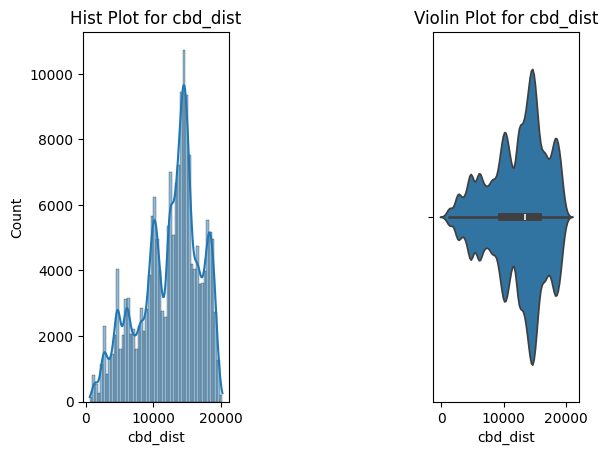

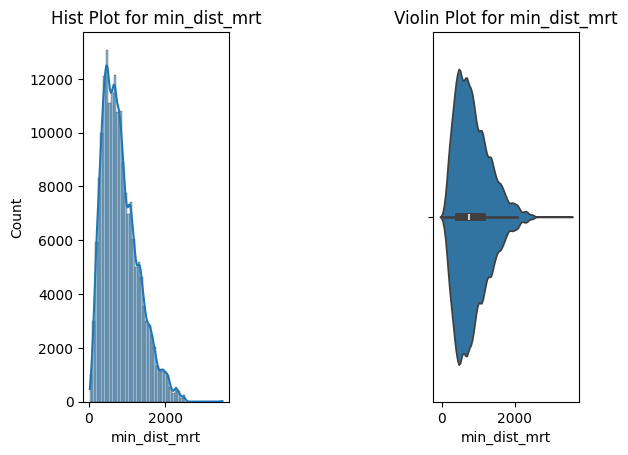

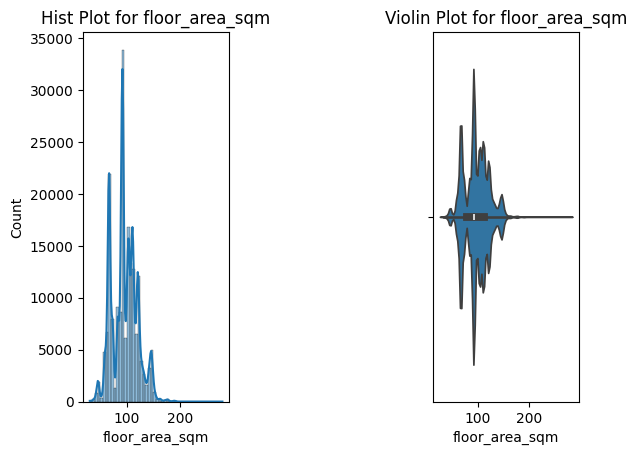

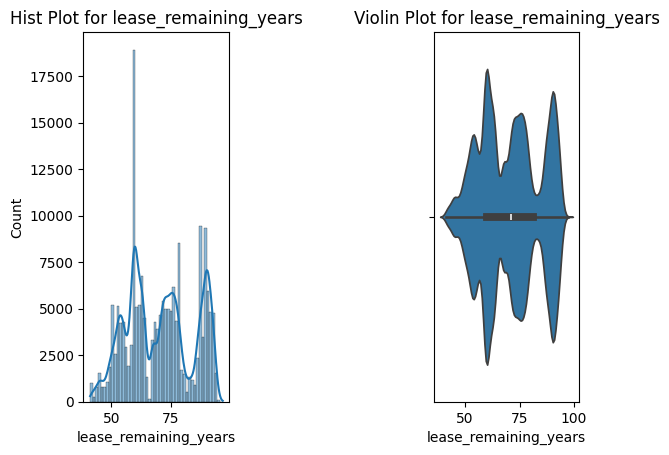

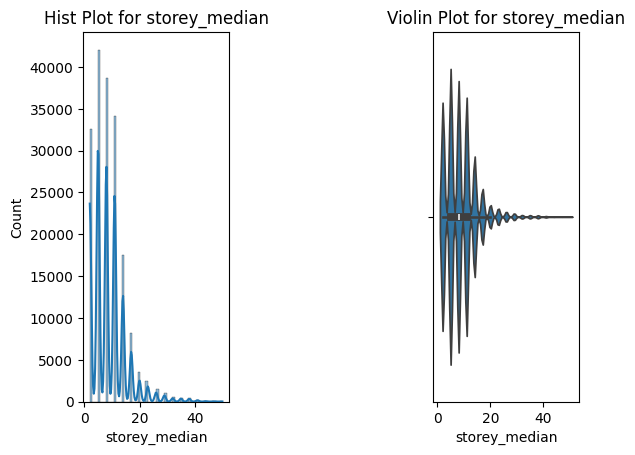

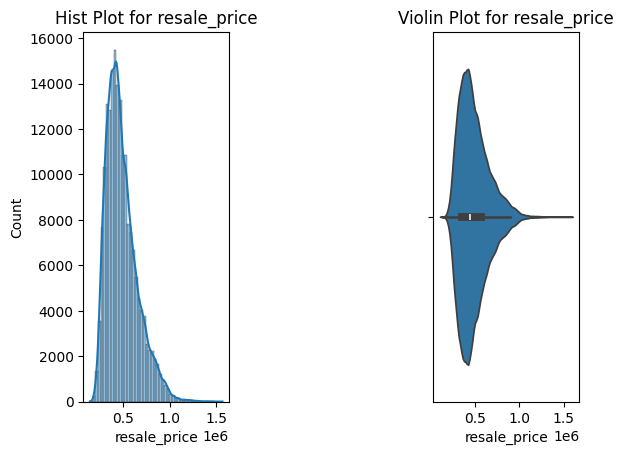

In [13]:
df1 = req_df.copy()
columns = ['cbd_dist','min_dist_mrt','floor_area_sqm','lease_remaining_years','storey_median','resale_price']
find_skewness(df1, columns)

In [14]:
df1['floor_area_sqm_log']=np.log(df1['floor_area_sqm'])
df1['lease_remaining_years_log']=np.log(df1['lease_remaining_years'])
df1['cbd_dist_log'] = np.log(df1['cbd_dist'])
df1['min_dist_mrt_log'] = np.log(df1['min_dist_mrt'])
df1['storey_median_log'] = np.log(df1['storey_median'])
df1['resale_price_log'] = np.log(df1['resale_price'])
df1

,town,flat_type,block,flat_model,cbd_dist,min_dist_mrt,floor_area_sqm,lease_remaining_years,storey_median,resale_price,floor_area_sqm_log,lease_remaining_years_log,cbd_dist_log,min_dist_mrt_log,storey_median_log,resale_price_log
0,ANG MO KIO,3 ROOM,174,Improved,10296.855747,1098.780832,60.0,61,8.0,255000.0,4.094345,4.110874,9.239594,7.001957,2.079442,12.449019
1,ANG MO KIO,3 ROOM,174,Improved,10296.855747,1098.780832,60.0,61,11.0,275000.0,4.094345,4.110874,9.239594,7.001957,2.397895,12.524526
2,ANG MO KIO,3 ROOM,174,Improved,10296.855747,1098.780832,69.0,61,5.0,310000.0,4.234107,4.110874,9.239594,7.001957,1.609438,12.644328
3,ANG MO KIO,2 ROOM,174,Improved,10296.855747,1098.780832,45.0,61,8.0,253000.0,3.806662,4.110874,9.239594,7.001957,2.079442,12.441145
4,ANG MO KIO,3 ROOM,174,Improved,10296.855747,1098.780832,61.0,61,5.0,290000.0,4.110874,4.110874,9.239594,7.001957,1.609438,12.577636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189402,TAMPINES,3 ROOM,606A,Model A,12927.779965,1836.464335,68.0,95,11.0,508000.0,4.219508,4.553877,9.467134,7.515597,2.397895,13.138237
189403,TAMPINES,4 ROOM,606A,Model A,12927.779965,1836.464335,92.0,95,14.0,720000.0,4.521789,4.553877,9.467134,7.515597,2.639057,13.487006
189404,TAMPINES,4 ROOM,606A,Model A,12927.779965,1836.464335,92.0,95,14.0,745000.0,4.521789,4.553877,9.467134,7.515597,2.639057,13.521139
189405,TAMPINES,4 ROOM,606D,Model A,12928.291352,1800.198404,92.0,95,17.0,725000.0,4.521789,4.553877,9.467173,7.495652,2.833213,13.493927


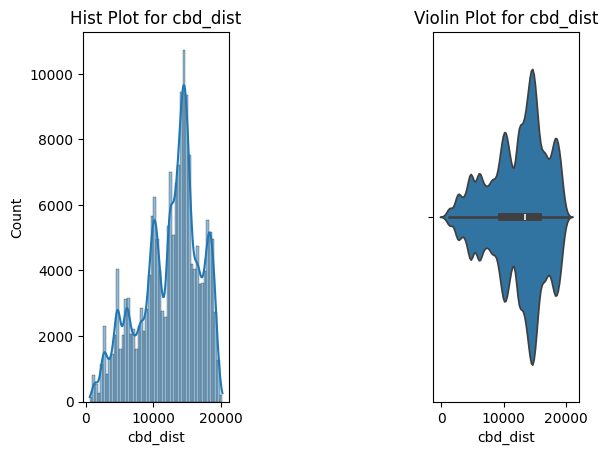

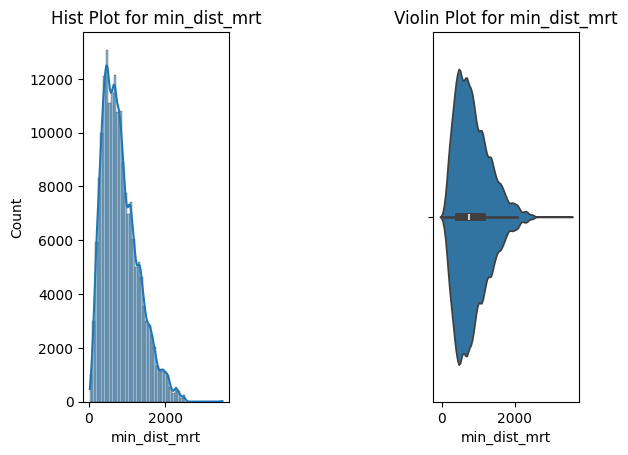

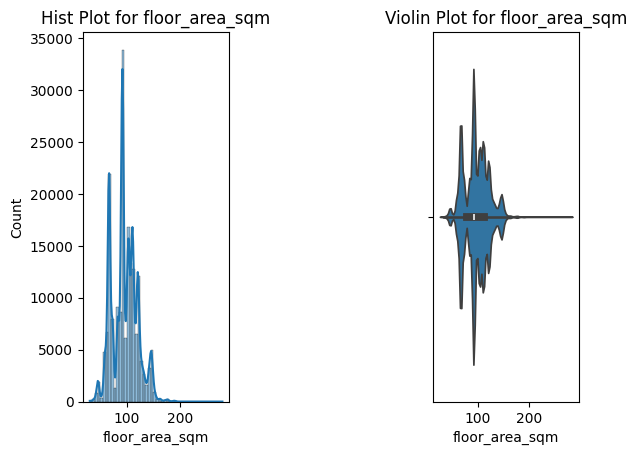

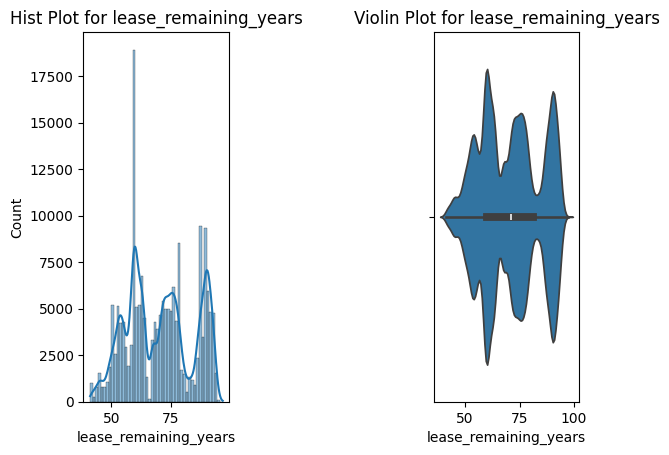

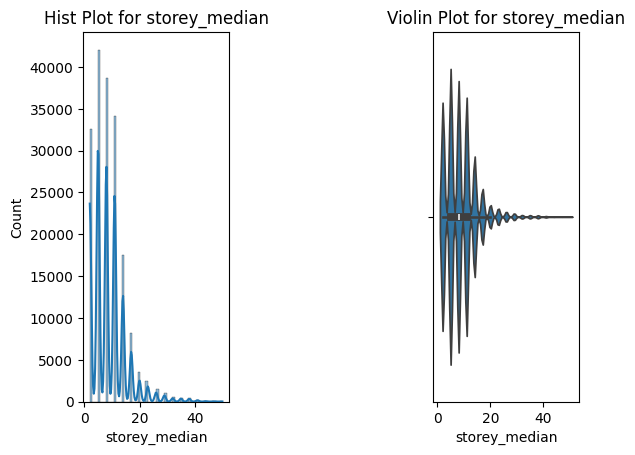

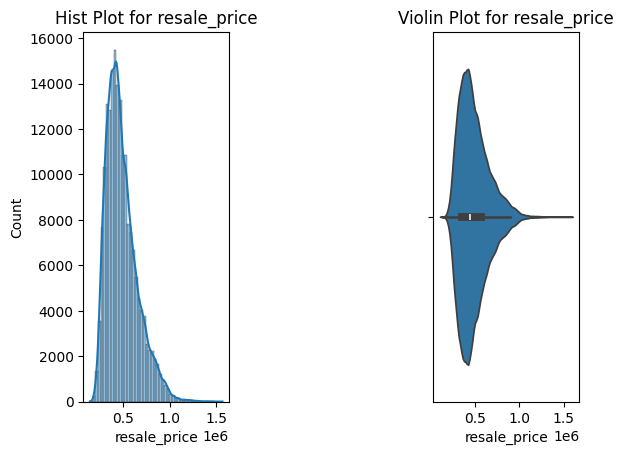

In [15]:
columns = ['cbd_dist','min_dist_mrt','floor_area_sqm','lease_remaining_years','storey_median','resale_price']
find_skewness(df1,columns)

##### Outlier Handling ( using Inter-Quartile Range Method and clip())

In [16]:
def find_outliers(df,col):
    print(col)
    for i in col:
        plt.figure(figsize=(4, 3))  
        sns.boxplot(data=df, x=i)
        plt.title(f'Boxplot of {i}')
        plt.xlabel(i)
        plt.show()

In [17]:
df2 = df1.copy()
df2

,town,flat_type,block,flat_model,cbd_dist,min_dist_mrt,floor_area_sqm,lease_remaining_years,storey_median,resale_price,floor_area_sqm_log,lease_remaining_years_log,cbd_dist_log,min_dist_mrt_log,storey_median_log,resale_price_log
0,ANG MO KIO,3 ROOM,174,Improved,10296.855747,1098.780832,60.0,61,8.0,255000.0,4.094345,4.110874,9.239594,7.001957,2.079442,12.449019
1,ANG MO KIO,3 ROOM,174,Improved,10296.855747,1098.780832,60.0,61,11.0,275000.0,4.094345,4.110874,9.239594,7.001957,2.397895,12.524526
2,ANG MO KIO,3 ROOM,174,Improved,10296.855747,1098.780832,69.0,61,5.0,310000.0,4.234107,4.110874,9.239594,7.001957,1.609438,12.644328
3,ANG MO KIO,2 ROOM,174,Improved,10296.855747,1098.780832,45.0,61,8.0,253000.0,3.806662,4.110874,9.239594,7.001957,2.079442,12.441145
4,ANG MO KIO,3 ROOM,174,Improved,10296.855747,1098.780832,61.0,61,5.0,290000.0,4.110874,4.110874,9.239594,7.001957,1.609438,12.577636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189402,TAMPINES,3 ROOM,606A,Model A,12927.779965,1836.464335,68.0,95,11.0,508000.0,4.219508,4.553877,9.467134,7.515597,2.397895,13.138237
189403,TAMPINES,4 ROOM,606A,Model A,12927.779965,1836.464335,92.0,95,14.0,720000.0,4.521789,4.553877,9.467134,7.515597,2.639057,13.487006
189404,TAMPINES,4 ROOM,606A,Model A,12927.779965,1836.464335,92.0,95,14.0,745000.0,4.521789,4.553877,9.467134,7.515597,2.639057,13.521139
189405,TAMPINES,4 ROOM,606D,Model A,12928.291352,1800.198404,92.0,95,17.0,725000.0,4.521789,4.553877,9.467173,7.495652,2.833213,13.493927


In [18]:
df2.dtypes

town                          object
flat_type                     object
block                         object
flat_model                    object
cbd_dist                     float64
min_dist_mrt                 float64
floor_area_sqm               float64
lease_remaining_years          int64
storey_median                float64
resale_price                 float64
floor_area_sqm_log           float64
lease_remaining_years_log    float64
cbd_dist_log                 float64
min_dist_mrt_log             float64
storey_median_log            float64
resale_price_log             float64
dtype: object

['floor_area_sqm_log', 'lease_remaining_years_log', 'cbd_dist_log', 'min_dist_mrt_log', 'storey_median_log', 'resale_price_log']


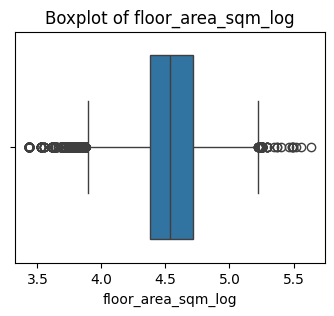

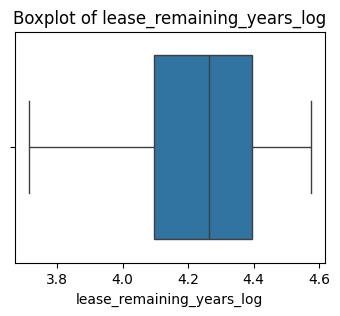

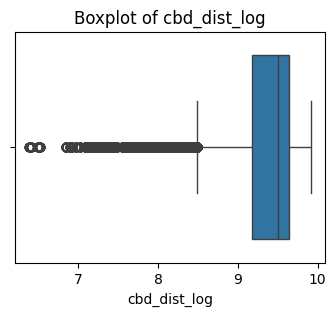

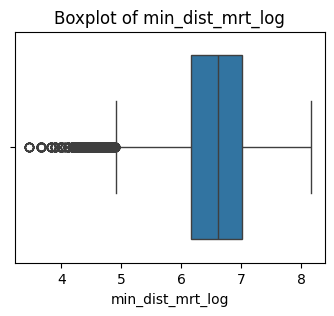

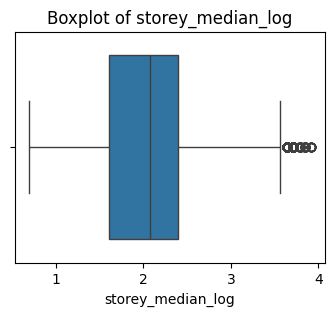

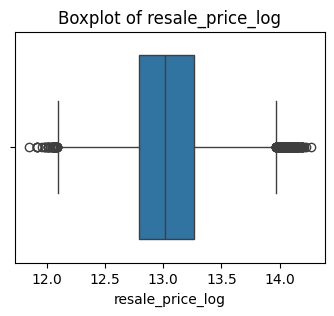

In [19]:
cols=['floor_area_sqm_log',
       'lease_remaining_years_log', 'cbd_dist_log', 'min_dist_mrt_log',
       'storey_median_log', 'resale_price_log']
find_outliers(df2,cols)

In [20]:
# Using IQR and clip() methods to handle the outliers and add a new column of dataframe
def outlier(df, column):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    upper_threshold = df[column].quantile(0.75) + (1.5*iqr)
    lower_threshold = df[column].quantile(0.25) - (1.5*iqr)
    df[column] = df[column].clip(lower_threshold, upper_threshold)

In [21]:
# Doing Data Transformation only for those columns which have outliers
outlier(df2, 'cbd_dist_log')
outlier(df2, 'min_dist_mrt_log')
outlier(df2, 'floor_area_sqm_log')
outlier(df2, 'storey_median_log')
outlier(df2, 'resale_price_log')

['floor_area_sqm_log', 'lease_remaining_years_log', 'cbd_dist_log', 'min_dist_mrt_log', 'storey_median_log', 'resale_price_log']


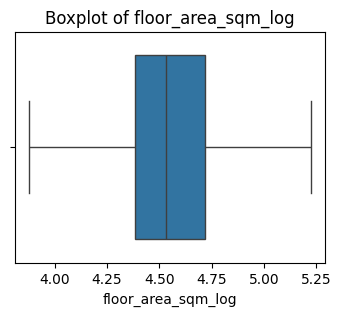

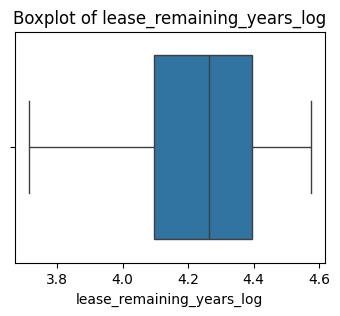

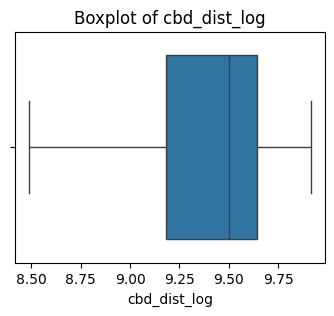

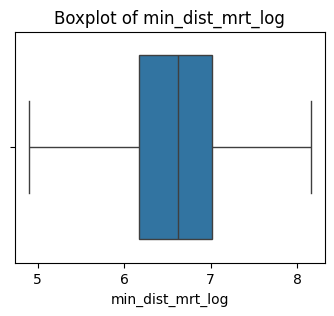

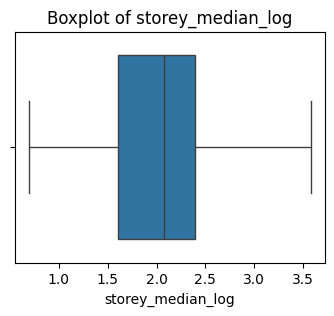

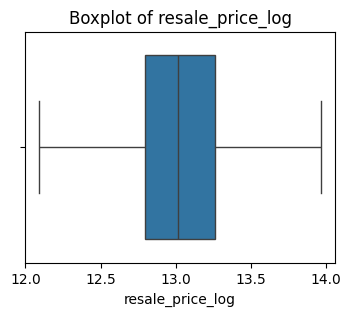

In [22]:
cols=['floor_area_sqm_log',
       'lease_remaining_years_log', 'cbd_dist_log', 'min_dist_mrt_log',
       'storey_median_log', 'resale_price_log']
find_outliers(df2,cols)

##### Detecting the Highly Correlated Data

In [23]:
# after add the new columns, drop the existing columns
df3 = df2.drop(columns=['cbd_dist','min_dist_mrt','floor_area_sqm','lease_remaining_years','storey_median','resale_price'])
df3

,town,flat_type,block,flat_model,floor_area_sqm_log,lease_remaining_years_log,cbd_dist_log,min_dist_mrt_log,storey_median_log,resale_price_log
0,ANG MO KIO,3 ROOM,174,Improved,4.094345,4.110874,9.239594,7.001957,2.079442,12.449019
1,ANG MO KIO,3 ROOM,174,Improved,4.094345,4.110874,9.239594,7.001957,2.397895,12.524526
2,ANG MO KIO,3 ROOM,174,Improved,4.234107,4.110874,9.239594,7.001957,1.609438,12.644328
3,ANG MO KIO,2 ROOM,174,Improved,3.877318,4.110874,9.239594,7.001957,2.079442,12.441145
4,ANG MO KIO,3 ROOM,174,Improved,4.110874,4.110874,9.239594,7.001957,1.609438,12.577636
...,...,...,...,...,...,...,...,...,...,...
189402,TAMPINES,3 ROOM,606A,Model A,4.219508,4.553877,9.467134,7.515597,2.397895,13.138237
189403,TAMPINES,4 ROOM,606A,Model A,4.521789,4.553877,9.467134,7.515597,2.639057,13.487006
189404,TAMPINES,4 ROOM,606A,Model A,4.521789,4.553877,9.467134,7.515597,2.639057,13.521139
189405,TAMPINES,4 ROOM,606D,Model A,4.521789,4.553877,9.467173,7.495652,2.833213,13.493927


In [24]:
df3.dtypes

town                          object
flat_type                     object
block                         object
flat_model                    object
floor_area_sqm_log           float64
lease_remaining_years_log    float64
cbd_dist_log                 float64
min_dist_mrt_log             float64
storey_median_log            float64
resale_price_log             float64
dtype: object

<Axes: >

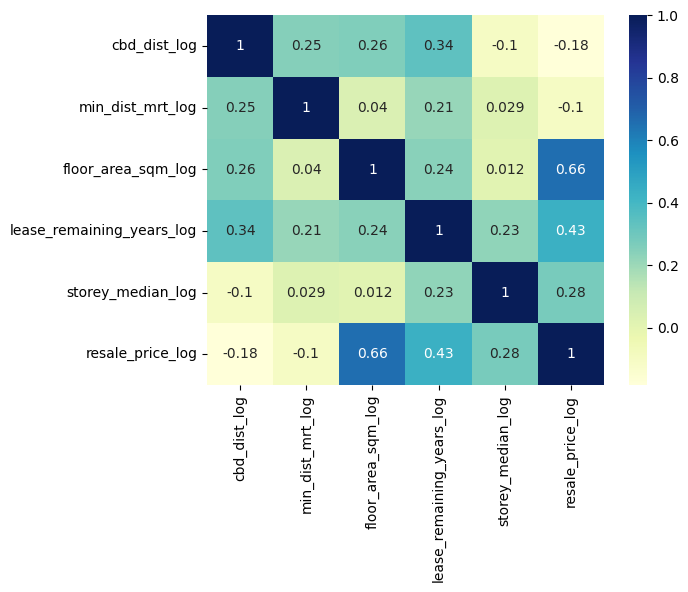

In [25]:
# Need to verify any columns are highly correlated using Heatmap. If any columns correlation value >= 0.7 (absolute value), drop the columns.
col = ['cbd_dist_log','min_dist_mrt_log','floor_area_sqm_log','lease_remaining_years_log','storey_median_log','resale_price_log']
df_heatmap = df3[col].corr()
sns.heatmap(df_heatmap, cmap="YlGnBu",annot=True)

In [ ]:
df3.to_csv("final_data.csv", index=False)

### EDA

In [20]:
df3.columns

Index(['town', 'flat_type', 'block', 'flat_model', 'floor_area_sqm_log',
       'lease_remaining_years_log', 'cbd_dist_log', 'min_dist_mrt_log',
       'storey_median_log', 'resale_price_log'],
      dtype='object')

In [21]:
df3

,town,flat_type,block,flat_model,floor_area_sqm_log,lease_remaining_years_log,cbd_dist_log,min_dist_mrt_log,storey_median_log,resale_price_log
0,ANG MO KIO,3 ROOM,174,Improved,4.094345,4.110874,9.239594,7.001957,2.079442,12.449019
1,ANG MO KIO,3 ROOM,174,Improved,4.094345,4.110874,9.239594,7.001957,2.397895,12.524526
2,ANG MO KIO,3 ROOM,174,Improved,4.234107,4.110874,9.239594,7.001957,1.609438,12.644328
3,ANG MO KIO,2 ROOM,174,Improved,3.877318,4.110874,9.239594,7.001957,2.079442,12.441145
4,ANG MO KIO,3 ROOM,174,Improved,4.110874,4.110874,9.239594,7.001957,1.609438,12.577636
...,...,...,...,...,...,...,...,...,...,...
189402,TAMPINES,3 ROOM,606A,Model A,4.219508,4.553877,9.467134,7.515597,2.397895,13.138237
189403,TAMPINES,4 ROOM,606A,Model A,4.521789,4.553877,9.467134,7.515597,2.639057,13.487006
189404,TAMPINES,4 ROOM,606A,Model A,4.521789,4.553877,9.467134,7.515597,2.639057,13.521139
189405,TAMPINES,4 ROOM,606D,Model A,4.521789,4.553877,9.467173,7.495652,2.833213,13.493927


##### Findout the relation between flat_type and resale_price

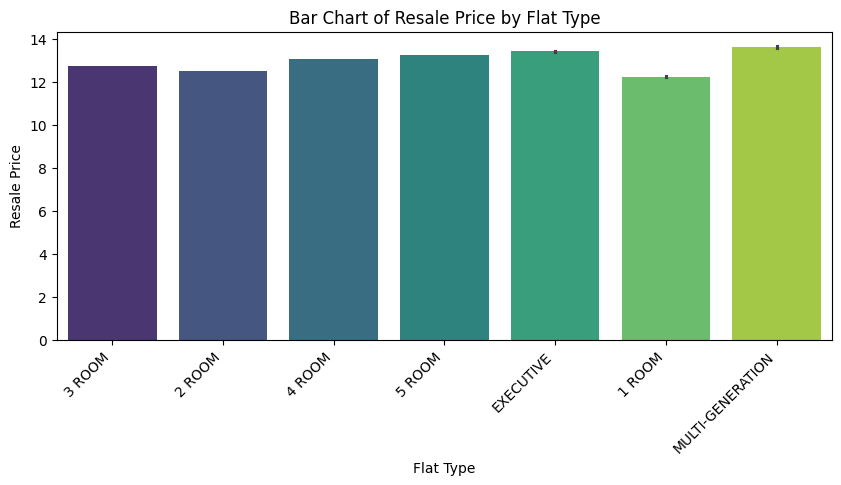

In [22]:
plt.figure(figsize=(10, 4))
sns.barplot(x='flat_type', y='resale_price_log', data=df3, palette='viridis')
plt.title('Bar Chart of Resale Price by Flat Type')
plt.xlabel('Flat Type')
plt.ylabel('Resale Price')
plt.xticks(rotation=45, ha='right')
plt.show()

##### No. of HDB Flats for resale based on Town

In [23]:
town_order = df3['town'].value_counts().index
town_order

Index(['SENGKANG', 'PUNGGOL', 'JURONG WEST', 'WOODLANDS', 'TAMPINES', 'YISHUN',
       'BEDOK', 'HOUGANG', 'CHOA CHU KANG', 'ANG MO KIO', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT BATOK', 'KALLANG/WHAMPOA', 'PASIR RIS',
       'TOA PAYOH', 'QUEENSTOWN', 'SEMBAWANG', 'GEYLANG', 'CLEMENTI',
       'JURONG EAST', 'BISHAN', 'SERANGOON', 'CENTRAL AREA', 'MARINE PARADE',
       'BUKIT TIMAH'],
      dtype='object', name='town')

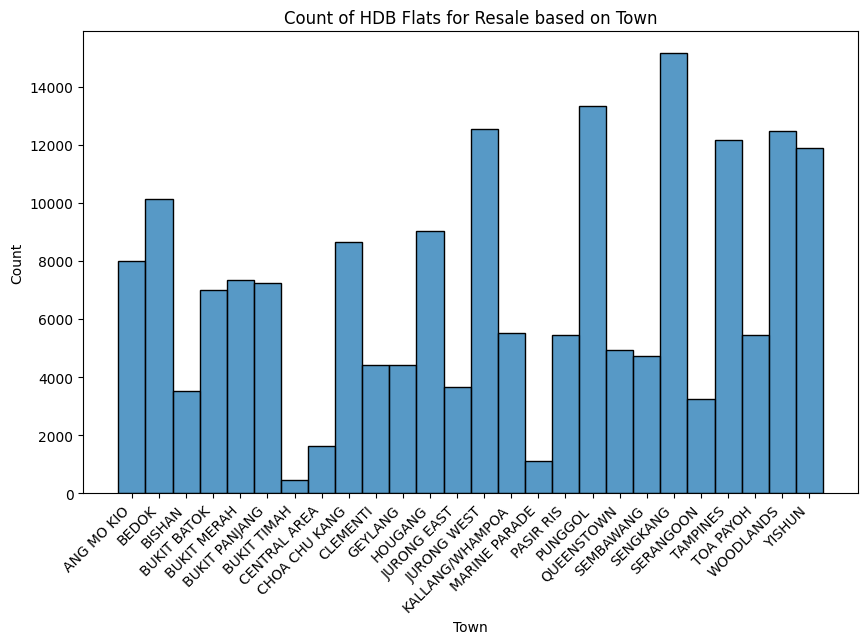

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df3, x='town', bins=len(town_order), palette='viridis')

plt.title('Count of HDB Flats for Resale based on Town')
plt.xlabel('Town')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

##### Find the floor_area_sqm for each flat_model and for each flat_type

Based on Flat_Model

In [25]:
grouped_data = df3.groupby('flat_model')['floor_area_sqm_log'].sum()

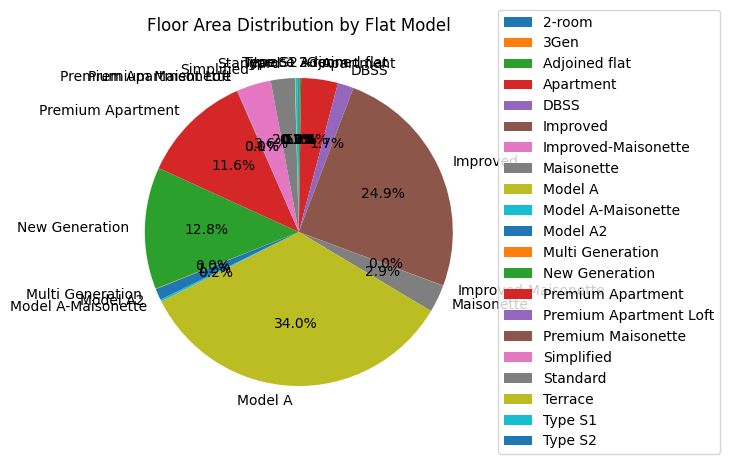

In [26]:
plt.figure(figsize=(6, 5))
plt.pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%', startangle=90, counterclock=False)

# Rotate labels to prevent overlap
plt.legend(grouped_data.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Floor Area Distribution by Flat Model')
plt.show()

Based on Flat_type

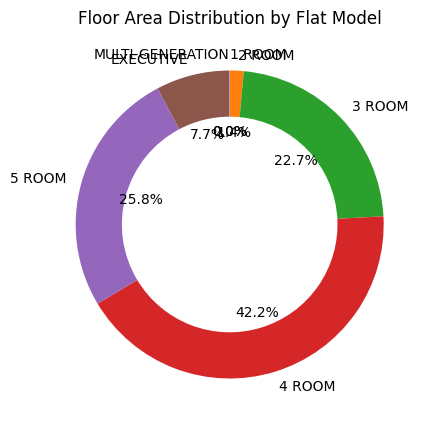

In [28]:
grouped_data = df3.groupby('flat_type')['floor_area_sqm_log'].sum()

plt.figure(figsize=(6, 5))  # Adjust the figure size as needed

# Plot outer circle (pie chart)
outer_circle = plt.pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3))

# Plot inner circle (white circle)
centre_circle = plt.Circle((0,0),0.2,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Floor Area Distribution by Flat Type')
plt.show()

##### Resale Prices based on Lease Remaining Years

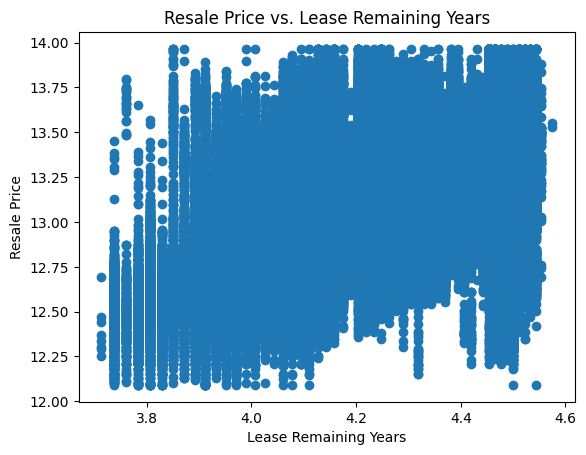

In [29]:
plt.scatter(data=df3,x='lease_remaining_years_log',y='resale_price_log')
plt.xlabel('Lease Remaining Years')
plt.ylabel('Resale Price')
plt.title('Resale Price vs. Lease Remaining Years')
plt.show()

##### No. of HDB Flats based on Block

In [30]:
block = df3['block'].value_counts().index

In [35]:
block

Index(['8', '1', '9', '2', '113', '101', '3', '107', '7', '6',
       ...
       '496F', '42A', '860B', '858B', '860A', '226E', '437A', '460A', '226F',
       '606D'],
      dtype='object', name='block', length=2604)

In [31]:
df_sorted = df3.sort_values(by='block', ascending=False)
top_100_descending = df_sorted.head(100)

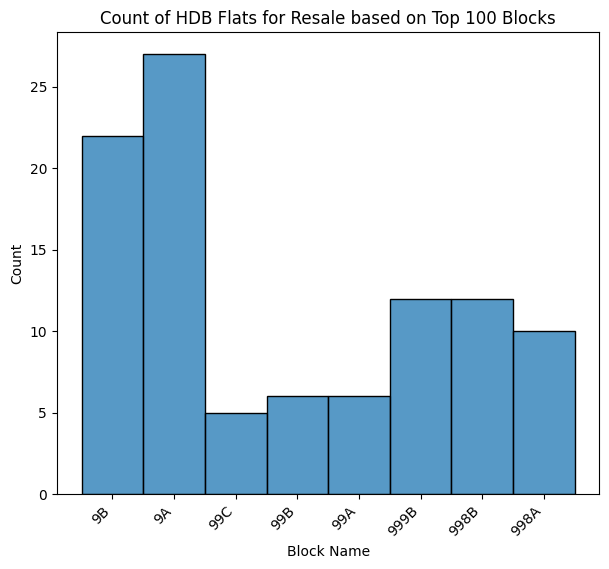

In [32]:
plt.figure(figsize=(7, 6))
sns.histplot(data=top_100_descending, x='block', bins=len(block))
plt.title('Count of HDB Flats for Resale based on Top 100 Blocks')
plt.xlabel('Block Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

##### Resale Price by Flat Type

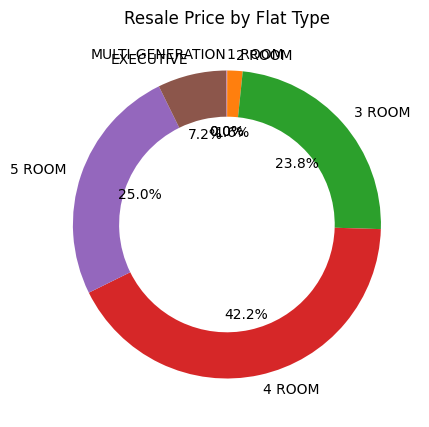

In [33]:
grouped_data = df3.groupby('flat_type')['resale_price_log'].sum()
plt.figure(figsize=(6, 5))  # Adjust the figure size as needed

# Plot outer circle (pie chart)
outer_circle = plt.pie(grouped_data, labels=grouped_data.index, autopct='%1.1f%%', startangle=90, counterclock=False, wedgeprops=dict(width=0.3))

# Plot inner circle (white circle)
centre_circle = plt.Circle((0,0),0.2,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Resale Price by Flat Type')
plt.show()

##### Get the Flat Locations on Folium Map

In [34]:
coor_df = pd.read_csv('df_flat_coordinates.csv')
coor_df

,latitude,longitude,blk_no,road_name,postal_code,address,cbd_dist,min_dist_mrt
0,1.375097,103.837619,174,ANG MO KIO AVENUE 4,560174,174 ANG MO KIO AVE 4,10296.855747,1098.780832
1,1.373922,103.855621,541,ANG MO KIO AVENUE 10,560541,541 ANG MO KIO AVE 10,10065.227934,806.176499
2,1.373552,103.838169,163,ANG MO KIO AVENUE 4,560163,163 ANG MO KIO AVE 4,10118.831546,1174.458648
3,1.367761,103.855357,446,ANG MO KIO AVENUE 10,560446,446 ANG MO KIO AVE 10,9383.300476,688.601573
4,1.371626,103.857736,557,ANG MO KIO AVENUE 10,560557,557 ANG MO KIO AVE 10,9825.917255,929.164159
...,...,...,...,...,...,...,...,...
8573,1.322388,103.862439,26A,SAINT GEORGE'S LANE,321026,26A ST. GEORGE'S LANE,4528.332931,274.150118
8574,1.412391,103.898234,323A,SUMANG WALK,821323,323A SUMANG WALK,15231.037948,1357.226309
8575,1.362377,103.936587,606A,TAMPINES STREET 61,521606,606A TAMPINES ST 61,12927.779965,1836.464335
8576,1.361851,103.937073,606D,TAMPINES STREET 61,524606,606D TAMPINES ST 61,12928.291352,1800.198404


In [36]:
map = folium.Map(location=(1.375097,103.837619),zoom_start=7,no_wrap=True)

i=0
for index, row in coor_df.iterrows():
    if i==100:
        break
    loc=[float(row['latitude']),float(row['longitude'])]
    folium.Marker(loc,tooltip=row['address']).add_to(map)
    i+=1
map

### Model Building

##### Regression Method - To Predict Resale Price as Output is Numerical

In [37]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import pickle

In [38]:
df4 = df3.drop(columns=['town','flat_type','block','flat_model'], axis=1)
df4

,floor_area_sqm_log,lease_remaining_years_log,cbd_dist_log,min_dist_mrt_log,storey_median_log,resale_price_log
0,4.094345,4.110874,9.239594,7.001957,2.079442,12.449019
1,4.094345,4.110874,9.239594,7.001957,2.397895,12.524526
2,4.234107,4.110874,9.239594,7.001957,1.609438,12.644328
3,3.877318,4.110874,9.239594,7.001957,2.079442,12.441145
4,4.110874,4.110874,9.239594,7.001957,1.609438,12.577636
...,...,...,...,...,...,...
189402,4.219508,4.553877,9.467134,7.515597,2.397895,13.138237
189403,4.521789,4.553877,9.467134,7.515597,2.639057,13.487006
189404,4.521789,4.553877,9.467134,7.515597,2.639057,13.521139
189405,4.521789,4.553877,9.467173,7.495652,2.833213,13.493927


##### Normalising the dataset

1. StandardScaler is used to standardize the input data in a way that ensures that the data points have a balanced scale.

2. Use StandardScaler if you want each feature to have zero-mean, unit standard-deviation. If you want more normally distributed data, and are okay with transforming your data.

In [39]:
from sklearn.preprocessing import StandardScaler

X=df4.drop(columns=['resale_price_log'], axis=1)
y=df4['resale_price_log']

# Normalizing the encoded data
scaler = StandardScaler()
X = scaler.fit_transform(X)

##### Finding out the Optimal ML Solution based on Accuracy Score

In [40]:
# check the train and test accuracy using R2 (R-squared ---> coefficient of determination) to predict resale price of flats
def machine_learning_regression(x,y, algorithm):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

    model = algorithm().fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # algo = str(algorithm).split("'")[1].split(".")[-1]
    accuracy_metrics = {'algorithm': algorithm.__name__,
                        'R2_train' : r2_train,
                        'R2_test'  : r2_test}

    return accuracy_metrics

In [41]:
print(machine_learning_regression(X,y, LinearRegression))
print(machine_learning_regression(X,y, DecisionTreeRegressor))
print(machine_learning_regression(X,y, RandomForestRegressor))
print(machine_learning_regression(X,y, GradientBoostingRegressor))
print(machine_learning_regression(X,y, XGBRegressor))

{'algorithm': 'LinearRegression', 'R2_train': 0.7611250028000541, 'R2_test': 0.7567412983348522}
{'algorithm': 'DecisionTreeRegressor', 'R2_train': 0.9424554635793014, 'R2_test': 0.8080858235010149}
{'algorithm': 'RandomForestRegressor', 'R2_train': 0.936951839418787, 'R2_test': 0.849294963570533}
{'algorithm': 'GradientBoostingRegressor', 'R2_train': 0.8326085894275906, 'R2_test': 0.8274074552517753}
{'algorithm': 'XGBRegressor', 'R2_train': 0.8814461168658398, 'R2_test': 0.8705817913264587}


##### Training the Model

As we can see from the Accuracy Score of different regression algorithms, DecisionTreeRegressor stands out to be highly accurate and we will use this algorithm to train our model and finally predict Resale Price based on user inputs

But the model seems to be highly accurate which leads to overfitting.
To eliminate overfitting, we will use Cross Validation Techniques

In [42]:
from sklearn.model_selection import train_test_split

# test and train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Decision Tree Regressor
dtr = DecisionTreeRegressor()

# hyperparameters
param_grid = {
    'max_depth': [2, 5, 10, 15, 20, 22],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2']
}

# gridsearchcv
grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# evalution metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(" ")
print('Mean squared error:', mse)
print('Mean Absolute Error', mae)
print('Root Mean squared error:', rmse)
print(" ")
print('R-squared:', r2)

Best hyperparameters: {'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 9, 'min_samples_split': 5}
 
Mean squared error: 0.014974645688316166
Mean Absolute Error 0.09711731127390404
Root Mean squared error: 0.12237093481834714
 
R-squared: 0.8601222538384905


##### Testing our Model on manual inputs

Scale the manual inputs for the 5 features needed to predict the Resale Price

In [47]:
# Array contains : [ floor_area_sqm_log,  lease_remaining_years_log,
#                   cbd_dist_log, min_dist_mrt_log,  storey_median_log]

input = np.array([[np.log(44),8740, 999,55, np.log(11)]])
input = scaler.transform(input[:, :5])
new_pred = best_model.predict(input)[0]

Using Inverse Log Transformation to convert the value to original scale of the data (exp)

In [48]:
np.exp(new_pred)

341443.1784542271

Saving the model

In [46]:
with open('regression_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [2]:
import sklearn
import matplotlib
import folium
import time
import json
print(folium.__version__)
print(sklearn.__version__)
print(json.__version__)

0.14.0
1.2.2
2.0.9
